In [1]:
# TAREAS DE LOS MÓDULOS DE CNN Y RNN - MIAX9
# Para cada uno de los siguientes ejercicios entregar un fichero en ipython notebook  (.ipynb).
# En cada fichero tenéis que solucionar un ejercicio distinto, es importante que comentéis la
# solución que habéis realizado y los resultados obtenidos.
# El código ha de ser compilable desde Google Colab (utilizando el entorno de Colab), y no
# ha de contener errores. En los casos en los que se pide entrenar un modelo razona sobre
# la evolución del error de entrenamiento y de validación durante el entrenamiento.
# La práctica deberá realizarse de manera individual y debe entregarse en la plataforma de
# Instituto BME.

In [2]:
# 9.- Crea una capa GDN 1D (puedes usar como base la GDN 2D que tenéis en el diccionario
# de Keras / Custom). Diseña un modelo en Keras que utilice al menos la capa diseñada y
# capas convolucionales 1D para estimar los valores de cierre Amazon utilizando los datos
# del ejercicio 5.

In [3]:
#from __future__ import absolute_import, division, print_function, unicode_literals
# Installa TensorFlow
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, LSTM, GRU, MaxPooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Bidirectional, Reshape, Activation, MaxPooling1D

import numpy as np
import pandas as pd

from tensorflow import keras


import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10

#import keras
from tensorflow.keras.layers import Layer, Conv2D, AveragePooling2D, Flatten, Dense, Softmax, ReLU
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.constraints import NonNeg

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import random

from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline

2.11.0


In [4]:
def datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model):
    salida=np.zeros((17))
    #trainableParams
    salida[0] = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    #nonTrainableParams
    salida[1] = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    #totalParams
    salida[2] = salida[0] + salida[1]
    
    #Train
    score = model.evaluate(x_train, t_train)
    salida[3] = score[0]
    salida[4] = score[1]
    y_hat = model.predict(x_train)
    # El  error de la predicion en train
    salida[5] = np.mean(abs(y_hat[:,0]-t_train))
    # La media de error en la prediccion en train 
    salida[6] =np.mean(np.abs(t_train))
    
    #Test
    score = model.evaluate(x_test, t_test)
    salida[7] = score[0]
    salida[8] = score[1]
    y_hat_test = model.predict(x_test)
    # El  error de la predicion en test
    salida[9] = np.mean(abs(y_hat_test[:,0]-t_test))
    # La media de error en la prediccion en test
    salida[10] = np.mean(np.abs(t_test))
    
    # numero de datos de entrada en train
    salida[11] = x_train.shape[0]
    #dimensiones de la entrada
    salida[12] =len(x_train.shape)
    # valor de la dimension 1 de la entrada
    if salida[12] >= 1:
        salida[13] = x_train.shape[0]
    # valor de la dimension 2 de la entrada
    if salida[12] >= 2:
        salida[14] = x_train.shape[1]
    # valor de la dimension 3 de la entrada
    if salida[12] >= 3:
        salida[15] = x_train.shape[2]
    # valor de la dimension 4 de la entrada
    if salida[12] >= 4:
        salida[16] = x_train.shape[3]
    
    print(len(salida))
    
    import pandas as pd 
    df = pd.read_csv ('metricas.csv', index_col=0) 
    print(df.shape)
    df[model_title] = salida
    df.to_csv('metricas.csv') 

    return salida, df


In [5]:
class GDN(Layer):
    def __init__(self, 
                 #filter_shape = (3,3), 
                 #filter_shape = (0,3), 
                 filter_shape = (3),
                 **kwargs):
      
        self.filter_shape = filter_shape

        super(GDN, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.beta = self.add_weight(name = 'beta', 
                                    shape = (input_shape.as_list()[-1]),
                                    initializer = tf.keras.initializers.constant(0.001),
                                    trainable = True,
                                    constraint = lambda x: tf.clip_by_value(x, 1e-15, np.inf))
        
        self.alpha = self.add_weight(name = 'alpha', 
                                     shape = (input_shape.as_list()[-1]),
                                     initializer = tf.keras.initializers.constant(2.0),
                                     trainable = True,
                                     constraint = NonNeg())

        self.epsilon = self.add_weight(name = 'epsilon', 
                                     shape = (input_shape.as_list()[-1]),
                                     initializer = tf.keras.initializers.constant(0.5),
                                     trainable = True,
                                     constraint = NonNeg())
        
        self.gamma = self.add_weight(name = 'gamma', 
                                     #shape = (self.filter_shape[0], self.filter_shape[1], input_shape.as_list()[-1], input_shape.as_list()[-1]),
                                     #shape = (self.filter_shape, 0, input_shape.as_list()[-1], input_shape.as_list()[-1]),
                                     shape = (self.filter_shape, input_shape.as_list()[-1], input_shape.as_list()[-1]),
                                     initializer = tf.keras.initializers.Ones,
                                     trainable = True,
                                     constraint = NonNeg())
        
        
        super(GDN, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        norm_conv2 = tf.nn.convolution(tf.abs(x)**self.alpha,
                                      self.gamma,
                                      
                                      #strides = (1, 1),
                                      #strides = (0,1),
                                      strides = 1,
                                      padding = "SAME",
                                      data_format = "NHWC")

        norm_conv = self.beta + norm_conv2
        norm_conv = norm_conv**self.epsilon
        return x / norm_conv
        
    def compute_output_shape(self, input_shape):
        return (input_shape, self.output_dim)

In [6]:
def sacar_open_5_valores_normalizado_y_con_numero_de_valores_SIN_RETORNO_LOG_AMAZON ():
    # Para leer datos lo mejor es usar la toolbox pandas
    # Los datos se han sacado de:
    # https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3
    
    
    dd_amzn = pd.read_csv("amzn.us.txt", delimiter=",")
    dd_msft = pd.read_csv("msft.us.txt", delimiter=",")
    dd_fb = pd.read_csv("fb.us.txt", delimiter=",")
    dd_aapl = pd.read_csv("aapl.us.txt", delimiter=",")
    dd_googl = pd.read_csv("googl.us.txt", delimiter=",")
    
    
    amzn_op = dd_amzn['Open'].values
    msft_op = dd_msft['Open'].values
    fb_op = dd_fb['Open'].values
    aapl_op = dd_aapl['Open'].values
    googl_op = dd_googl['Open'].values
    
    print(amzn_op.shape)
    print(msft_op.shape)
    print(fb_op.shape)
    print(aapl_op.shape)
    print(googl_op.shape)
    
    # Como no coinciden en el tiempo los 5 valores me cojo solo los que coinciden
    # Primero me los ordeno teniendo en cuenta la fecha
    aa = dd_amzn['Date'].values #
    amzn_indice = np.zeros(aa.shape) #
    for n in range(0, aa.shape[0]):
        cc = aa[n]
        qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
        qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
        qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

        amzn_indice[n] = (qq1-2000)*365 + qq2*30 + qq3 #


    aa = dd_msft['Date'].values #
    msft_indice = np.zeros(aa.shape) #
    for n in range(0, aa.shape[0]):
        cc = aa[n]
        qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
        qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
        qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

        msft_indice[n] = (qq1-2000)*365 + qq2*30 + qq3 #

    aa = dd_fb['Date'].values #
    fb_indice = np.zeros(aa.shape) #
    for n in range(0, aa.shape[0]):
        cc = aa[n]
        qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
        qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
        qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

        fb_indice[n] = (qq1-2000)*365 + qq2*30 + qq3 #

    aa = dd_aapl['Date'].values #
    aapl_indice = np.zeros(aa.shape) #
    for n in range(0, aa.shape[0]):
        cc = aa[n]
        qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
        qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
        qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

        aapl_indice[n] = (qq1-2000)*365 + qq2*30 + qq3 #

    aa = dd_googl['Date'].values #
    googl_indice = np.zeros(aa.shape) #
    for n in range(0, aa.shape[0]):
        cc = aa[n]
        qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
        qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
        qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

        googl_indice[n] = (qq1-2000)*365 + qq2*30 + qq3 #
    
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10)) 
    
    
    # Los ploteo y veo que hay un tramo en el coinciden las fechas
    #import matplotlib.pyplot as plt
    #%matplotlib inline
    #plt.figure()
    ax1.plot(amzn_indice,amzn_op, label='amzn_indice,amzn_op')
    ax1.plot(msft_indice,msft_op, label='msft_indice,msft_opp')
    ax1.plot(fb_indice,fb_op, label='fb_indice,fb_op')
    ax1.plot(aapl_indice,aapl_op, label='aapl_indice,aapl_op')
    ax1.plot(googl_indice,googl_op, label='googl_indice,googl_op')
    ax1.legend()
    
    # Me quedo solo las fechas que coinciden
    indices = set(amzn_indice) & set(msft_indice) & set(fb_indice) & set(aapl_indice) & set(aapl_indice)

    ii = np.in1d(amzn_indice,list(indices))
    data_amzn = amzn_op[ii]
    ii = np.in1d(msft_indice,list(indices))
    data_msft = msft_op[ii]
    ii = np.in1d(fb_indice,list(indices))
    data_fb = fb_op[ii]
    ii = np.in1d(aapl_indice,list(indices))
    data_aapl = aapl_op[ii]
    ii = np.in1d(googl_indice,list(indices))
    data_googl = googl_op[ii]



    # Los ploteo y ahora síí coinciden en todo el tramo
    #import matplotlib.pyplot as plt
    #%matplotlib inline
    #plt.figure()
    ax2.plot(data_amzn, label='data_amzn')
    ax2.plot(data_msft, label='data_msft')
    ax2.plot(data_fb, label='data_fb')
    ax2.plot(data_aapl, label='data_aapl')
    ax2.plot(data_googl, label='data_googl')
    ax2.legend()
    
    # Los coloco todos juntos en un dataset
    DAT = np.zeros((data_googl.shape[0],5))
    DAT[:,0] = data_amzn # PONGO AMAZON PRIMERA PARA QUE LA FUNCION ME DE ESTA COMO VALOR DE T
    DAT[:,1] = data_msft
    DAT[:,2] = data_fb
    DAT[:,3] = data_aapl
    DAT[:,4] = data_googl

    # Los ploteo
    #import matplotlib.pyplot as plt
    #%matplotlib inline
    #plt.figure()
    ax3.plot(DAT[:,1], label='data_msft')
    ax3.plot(DAT[:,0], label='data_amzn')# PONGO AMAZON PRIMERA PARA QUE LA FUNCION ME DE ESTA COMO VALOR DE T
    ax3.plot(DAT[:,2], label='data_fb')
    ax3.plot(DAT[:,3], label='data_aapl')
    ax3.plot(DAT[:,4], label='data_googl')
    ax3.legend()
    
    #normalizo de 0 a 1. Esto no cubre la ############### pero me deja todo normalizado
    # se podria usar a lo menos DAT = StandardScaler().fit_transform(DAT). 
    # pero se a usado para otro tipo de casos y me da valores mayoires de 1 y menores de -1
    DAT[:,0] = DAT[:,0]/DAT[:,0].max()
    DAT[:,1] = DAT[:,1]/DAT[:,1].max()
    DAT[:,2] = DAT[:,2]/DAT[:,2].max()
    DAT[:,3] = DAT[:,3]/DAT[:,3].max()
    DAT[:,4] = DAT[:,4]/DAT[:,4].max()
    
    # Los ploteo
    #import matplotlib.pyplot as plt
    #%matplotlib inline
    #plt.figure()
    ax4.plot(DAT[:,1], label='data_msft')
    ax4.plot(DAT[:,0], label='data_amzn')# PONGO AMAZON PRIMERA PARA QUE LA FUNCION ME DE ESTA COMO VALOR DE T
    ax4.plot(DAT[:,2], label='data_fb')
    ax4.plot(DAT[:,3], label='data_aapl')
    ax4.plot(DAT[:,4], label='data_googl')
    ax4.legend()

    
    return DAT



In [7]:
def sacar_open_5_valores_SIN_normalizado_y_con_numero_de_valores_CON_RETORNO_LOG_AMAZON ():
    # Para leer datos lo mejor es usar la toolbox pandas
    # Los datos se han sacado de:
    # https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3
    
    
    dd_amzn = pd.read_csv("amzn.us.txt", delimiter=",")
    dd_msft = pd.read_csv("msft.us.txt", delimiter=",")
    dd_fb = pd.read_csv("fb.us.txt", delimiter=",")
    dd_aapl = pd.read_csv("aapl.us.txt", delimiter=",")
    dd_googl = pd.read_csv("googl.us.txt", delimiter=",")
    
    
    amzn_op = dd_amzn['Open'].values
    msft_op = dd_msft['Open'].values
    fb_op = dd_fb['Open'].values
    aapl_op = dd_aapl['Open'].values
    googl_op = dd_googl['Open'].values
    
    print(amzn_op.shape)
    print(msft_op.shape)
    print(fb_op.shape)
    print(aapl_op.shape)
    print(googl_op.shape)
    
    # Como no coinciden en el tiempo los 5 valores me cojo solo los que coinciden
    # Primero me los ordeno teniendo en cuenta la fecha
    aa = dd_amzn['Date'].values #
    amzn_indice = np.zeros(aa.shape) #
    for n in range(0, aa.shape[0]):
        cc = aa[n]
        qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
        qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
        qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

        amzn_indice[n] = (qq1-2000)*365 + qq2*30 + qq3 #


    aa = dd_msft['Date'].values #
    msft_indice = np.zeros(aa.shape) #
    for n in range(0, aa.shape[0]):
        cc = aa[n]
        qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
        qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
        qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

        msft_indice[n] = (qq1-2000)*365 + qq2*30 + qq3 #

    aa = dd_fb['Date'].values #
    fb_indice = np.zeros(aa.shape) #
    for n in range(0, aa.shape[0]):
        cc = aa[n]
        qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
        qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
        qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

        fb_indice[n] = (qq1-2000)*365 + qq2*30 + qq3 #

    aa = dd_aapl['Date'].values #
    aapl_indice = np.zeros(aa.shape) #
    for n in range(0, aa.shape[0]):
        cc = aa[n]
        qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
        qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
        qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

        aapl_indice[n] = (qq1-2000)*365 + qq2*30 + qq3 #

    aa = dd_googl['Date'].values #
    googl_indice = np.zeros(aa.shape) #
    for n in range(0, aa.shape[0]):
        cc = aa[n]
        qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
        qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
        qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

        googl_indice[n] = (qq1-2000)*365 + qq2*30 + qq3 #
    
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10)) 
    
    
    # Los ploteo y veo que hay un tramo en el coinciden las fechas
    #import matplotlib.pyplot as plt
    #%matplotlib inline
    #plt.figure()
    ax1.plot(amzn_indice,amzn_op, label='amzn_indice,amzn_op')
    ax1.plot(msft_indice,msft_op, label='msft_indice,msft_opp')
    ax1.plot(fb_indice,fb_op, label='fb_indice,fb_op')
    ax1.plot(aapl_indice,aapl_op, label='aapl_indice,aapl_op')
    ax1.plot(googl_indice,googl_op, label='googl_indice,googl_op')
    ax1.legend()
    
    # Me quedo solo las fechas que coinciden
    indices = set(amzn_indice) & set(msft_indice) & set(fb_indice) & set(aapl_indice) & set(aapl_indice)

    ii = np.in1d(amzn_indice,list(indices))
    data_amzn = amzn_op[ii]
    ii = np.in1d(msft_indice,list(indices))
    data_msft = msft_op[ii]
    ii = np.in1d(fb_indice,list(indices))
    data_fb = fb_op[ii]
    ii = np.in1d(aapl_indice,list(indices))
    data_aapl = aapl_op[ii]
    ii = np.in1d(googl_indice,list(indices))
    data_googl = googl_op[ii]



    # Los ploteo y ahora síí coinciden en todo el tramo
    #import matplotlib.pyplot as plt
    #%matplotlib inline
    #plt.figure()
    ax2.plot(data_amzn, label='data_amzn')
    ax2.plot(data_msft, label='data_msft')
    ax2.plot(data_fb, label='data_fb')
    ax2.plot(data_aapl, label='data_aapl')
    ax2.plot(data_googl, label='data_googl')
    ax2.legend()
    
    # Los coloco todos juntos en un dataset
    DAT = np.zeros((data_googl.shape[0],5))
    DAT[:,0] = data_amzn # PONGO AMAZON PRIMERA PARA QUE LA FUNCION ME DE ESTA COMO VALOR DE T
    DAT[:,1] = data_msft
    DAT[:,2] = data_fb
    DAT[:,3] = data_aapl
    DAT[:,4] = data_googl

    # Los ploteo
    #import matplotlib.pyplot as plt
    #%matplotlib inline
    #plt.figure()
    ax3.plot(DAT[:,1], label='data_msft')
    ax3.plot(DAT[:,0], label='data_amzn') # PONGO AMAZON PRIMERA PARA QUE LA FUNCION ME DE ESTA COMO VALOR DE T
    ax3.plot(DAT[:,2], label='data_fb')
    ax3.plot(DAT[:,3], label='data_aapl')
    ax3.plot(DAT[:,4], label='data_googl')
    ax3.legend()
    
 
    #Aplico el retorno logaritmico
    DAT_1 = np.diff(np.log(DAT),axis=0)

    
    # Los ploteo
    #import matplotlib.pyplot as plt
    #%matplotlib inline
    #plt.figure()
    ax4.plot(DAT_1[:,1], label='data_msft')
    ax4.plot(DAT_1[:,0], label='data_amzn') # PONGO AMAZON PRIMERA PARA QUE LA FUNCION ME DE ESTA COMO VALOR DE T
    ax4.plot(DAT_1[:,2], label='data_fb')
    ax4.plot(DAT_1[:,3], label='data_aapl')
    ax4.plot(DAT_1[:,4], label='data_googl')
    ax4.legend()
    
    return DAT_1

In [8]:
def Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG,DAT_1):
    # Reordeno el dataset para hacer bloques de LAG dias
    #LAG = 11
    DAT_TS = np.zeros((DAT_1.shape[0]-LAG,LAG,DAT_1.shape[1]))

    for ii in range(0,DAT_1.shape[0]-LAG):
        DAT_TS[ii,:,:] = DAT_1[ii:ii+LAG,:]
    # Tengo (#muestras,#longitud,#variables)


    #Separaro todo el dataset en los datos de apertura de 10 días anteriores para estimar el valor del día
    #actual
    #Ntr = np.floor(DAT_TS.shape[0]/2)
    Ntr = np.floor(DAT_TS.shape[0])
    data_x = DAT_TS[range(0,np.int(Ntr)),0:LAG-1,:]

    Y_target = 0
    data_y = DAT_TS[range(0,np.int(Ntr)),LAG-1,Y_target]

    #print(data_x[700])
    #print(data_y[700])


    #hago el split de train y test
    from sklearn.model_selection import train_test_split
    x_train, x_test, t_train, t_test = train_test_split(data_x, data_y, test_size=0.33, random_state=12)

    return x_train, x_test, t_train, t_test



In [9]:
#NO LO USARE AQUI P0R HAN DE SER 1D
def reshape_para_trabajar_conv2D (x_train,x_test):
    # Modifico las dimensiones para poder usar convoluciones 2D
    # Para eso incluyo una dimension de canales al final
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
    return x_train, x_test


In [10]:
# Evaluamos el modelo segun los datos mas generales para evaluarlo

def graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist):
    import matplotlib.pyplot as plt
    %matplotlib inline
    #Train
    score = model.evaluate(x_train, t_train)
    print('SCORE DE TRAIN:')
    print(score)

    #Test
    print('SCORE DE TEST:')
    score_1 = model.evaluate(x_test, t_test)
    print(score_1)

    n_epochs = len(hist.history['loss'])
    hd = hist.history
    epochs = range(1, n_epochs+1)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(epochs, hd['accuracy'], "r", label="train")
    plt.plot(epochs, hd['val_accuracy'], "b", label="valid")
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hd['loss'], "r", label="train")
    plt.plot(epochs, hd['val_loss'], "b", label="valid")
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss")
    plt.legend()
    plt.show()
    return score, score_1

In [11]:
#Cree esta funcion segun lo que Valero son ensenaba en clase
def ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model):
    
    #ESTUDIO GRAFICO DE RESULTADOS PARA EVALUAR
    # Evaluamos el modelo en train
    score = model.evaluate(x_train, t_train, verbose=0)
    print(f'Evaluamos el modelo en train_score: {score}')

    # Predecimos con los datos de train
    y_hat = model.predict(x_train)
    print(f'Predecimos con los datos de train: {np.mean(abs(y_hat[:,0]-t_train))}')
    print(f'Predecimos con los datos de train_cantidad/dimensiones de datos:{y_hat.shape}')
    print(f' La media de error en la prediccion en entrenamiento es: {np.mean(np.abs(t_train))}')

    # Predecimos con los datos de test
    y_hat_test = model.predict(x_test)
    print(f' El  error de la predicion usando datos de test es de : {np.mean(abs(y_hat_test[:,0]-t_test))}')
    print(f' La media de error en la prediccion en test es: {np.mean(np.abs(t_test))}')

    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, ((ax1, ax2),(ax3, ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(20, 10)) 
    # Mostramos las predicciones de entrenamiento
    print(f'Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:')

    #plt.figure()
    ax1.plot(y_hat[:,0], label='y_hat[:,0] datos')    
    ax1.plot(t_train, label='t_train predicciones')
    ax1.grid(True)
    #ax1.xlabel("valores")
    #ax1.ylabel("nuero de dato ordinalmente")
    ax1.legend()

    #plt.figure()
    ax2.plot(t_train,y_hat[:,0],'.', label='t_train VSy_hat[:,0],')
    ax2.grid(True)
    #ax2.xlabel("t_train")
    #ax2.ylabel("y_hat[:,0],")
    ax2.legend()

    # Mostramos las predicciones de test
    ax3.plot(y_hat_test[:,0], label='y_hat_test[:,0] datos')
    ax3.plot(t_test, label=' t_testpredicciones')
    ax3.grid(True)
    #ax3.xlabel("valores")
    #ax3.ylabel("nuero de dato ordinalmente")
    ax3.legend()

    ax4.plot(t_test,y_hat_test[:,0],'.', label='t_test VS y_hat_test[:,0]')
    ax4.grid(True)
    #ax4.xlabel("t_test")
    #ax4.ylabel("y_hat_test[:,0]")
    ax4.legend()

    
    ax5.plot(model.weights[0].numpy().reshape(-1),'o-',label="Pesos neurona primera capa")
    ax5.grid(True)
    #ax5.xlabel("numero de la neurona ordinalmente")
    #ax5.ylabel("peso de la neurona")
    #ax5.title("Pesos neurona primera capa")
    ax5.legend()
    
    return



In [12]:
def activo_caso_1(x_train, x_test, t_train, t_test):
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout,MaxPooling2D, Activation 
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, GlobalAveragePooling1D,GlobalMaxPooling1D
    from tensorflow.keras import regularizers
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np
    import matplotlib.pyplot as plt
    from time import time
    import shutil

    !pip install -q -U keras-tuner
    import keras_tuner as kt


    model = Sequential()
    model.add(GDN(input_shape = x_train.shape[1:]))
    model.add(Conv1D(10, 3, padding='same'))
    #model.add(Conv2D(10, 3, input_shape=x_train.shape[1:], padding='same'))    
    model.add(Activation("relu"))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(2))
    #model.add(MaxPooling2D(2))
    #model.add(Reshape((5*2,10))) #https://github.com/keras-team/keras/issues/4172
    model.add(LSTM(5,return_sequences=True))
    #model.add(Bidirectional(GRU(20), input_shape=(10,1), merge_mode="ave"))
    model.add(GRU(5))
    model.add(Flatten())
    model.add(Dense(1))


    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error', metrics=['accuracy'])
    #model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mae', metrics=['accuracy'])
    model.summary()

    # Vamos a usar el callback de earlystopping y ReduceLROnPlateau
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    #early_stopping = EarlyStopping(monitor='val_loss', patience=12, min_delta=0.1)
    early_stopping = EarlyStopping(monitor='loss', patience=12, min_delta=0.1)

    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.01)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=5, min_lr=0.1)


    # Entrenamos el modelo, nos guardamos la evolución en 'history' 
    # Esto es equivalente a usar callbacks para history
    hist = model.fit(x_train, t_train, batch_size=32, epochs=100, verbose=1, validation_split = 0.1) # antes epochs=1000
    
    #Parametros para evaluar
    score_train, score_test = graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist)
    ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model)
    
    return model, hist

In [13]:
def activo_caso_2(x_train, x_test, t_train, t_test):
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout,MaxPooling2D 
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, GlobalAveragePooling1D,GlobalMaxPooling1D
    from tensorflow.keras import regularizers
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np
    import matplotlib.pyplot as plt
    from time import time
    import shutil

    !pip install -q -U keras-tuner
    import keras_tuner as kt

    

    model = Sequential()
    model.add(GDN(input_shape = x_train.shape[1:]))
    model.add(Conv1D(10,3,padding='same'))
    #model.add(Conv2D(10,3, input_shape=(x_train.shape[1:]),padding='same'))
    #model.add(Reshape((10*5,10)))
    model.add(GRU(5,return_sequences=True))
    model.add(LSTM(5))
    model.add(Flatten())
    model.add(Dense(1))



    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error', metrics=['accuracy'])
    #model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mae', metrics=['accuracy'])
    model.summary()

    # Vamos a usar el callback de earlystopping y ReduceLROnPlateau
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    #early_stopping = EarlyStopping(monitor='val_loss', patience=12, min_delta=0.1)
    early_stopping = EarlyStopping(monitor='loss', patience=12, min_delta=0.1)

    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.01)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=5, min_lr=0.1)


    # Entrenamos el modelo, nos guardamos la evolución en 'history' 
    # Esto es equivalente a usar callbacks para history
    hist = model.fit(x_train, t_train, batch_size=32, epochs=100, verbose=1, validation_split = 0.1) # antes epochs=1000
    
    #Parametros para evaluar
    score_train, score_test = graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist)
    ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model)
    
    return model, hist

In [14]:
def activo_caso_3(x_train, x_test, t_train, t_test):
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout,MaxPooling2D 
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, GlobalAveragePooling1D,GlobalMaxPooling1D
    from tensorflow.keras import regularizers
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np
    import matplotlib.pyplot as plt
    from time import time
    import shutil

    !pip install -q -U keras-tuner
    import keras_tuner as kt

    

    # Otra posibilidad 2 convolucionales 2D y 2 densas
    

    model = Sequential()
    model.add(GDN(input_shape = x_train.shape[1:]))
    model.add(Conv1D(5, 3, padding='same'))
    #model.add(Conv2D(5, 3, input_shape=x_train.shape[1:], padding='same'))
    model.add(Conv1D(5, 3, padding='valid'))
    model.add(Flatten())
    model.add(Dense(3))
    model.add(Dense(1))



    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error', metrics=['accuracy'])
    #model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mae', metrics=['accuracy'])
    model.summary()

    # Vamos a usar el callback de earlystopping y ReduceLROnPlateau
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    #early_stopping = EarlyStopping(monitor='val_loss', patience=12, min_delta=0.1)
    early_stopping = EarlyStopping(monitor='loss', patience=12, min_delta=0.1)

    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.01)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=5, min_lr=0.1)


    # Entrenamos el modelo, nos guardamos la evolución en 'history' 
   
    hist = model.fit(x_train, t_train, batch_size=32, epochs=100, verbose=1, validation_split = 0.1) # antes epochs=1000
    
    #Parametros para evaluar
    score_train, score_test = graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist)
    ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model)
    
    return model, hist

In [15]:
def activo_caso_4(x_train, x_test, t_train, t_test):
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout,MaxPooling2D, Activation 
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, GlobalAveragePooling1D,GlobalMaxPooling1D
    from tensorflow.keras import regularizers
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np
    import matplotlib.pyplot as plt
    from time import time
    import shutil

    !pip install -q -U keras-tuner
    import keras_tuner as kt

    
    # modelo con 3 capas de Conv2D y con mas cositinas y una densa al final
    

    model = Sequential()
    #Vamos añadiendo capas
    #model.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=x_train.shape[1:], padding='same'))
    model.add(GDN(input_shape = x_train.shape[1:]))
    model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same'))
    #                activity_regularizer=regularizers.l1(0.2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    #model.add(MaxPooling2D(2))
    model.add(Conv1D(3, kernel_size=5, activation='relu', padding='same'))
    #                activity_regularizer=regularizers.l1(0.2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPooling1D())
    #model.add(MaxPooling2D())
    model.add(Conv1D(3, kernel_size=3, activation='relu', padding='same'))
    #                activity_regularizer=regularizers.l1(0.2)))
    model.add(MaxPooling1D(2))
    #model.add(MaxPooling2D(2))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))




    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error', metrics=['accuracy'])
    #model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mae', metrics=['accuracy'])
    model.summary()

    # Vamos a usar el callback de earlystopping y ReduceLROnPlateau
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    #early_stopping = EarlyStopping(monitor='val_loss', patience=12, min_delta=0.1)
    early_stopping = EarlyStopping(monitor='loss', patience=12, min_delta=0.1)

    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.01)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=5, min_lr=0.1)


    # Entrenamos el modelo, nos guardamos la evolución en 'history' 
    hist = model.fit(x_train, t_train, batch_size=32, epochs=100, verbose=1, validation_split = 0.1) # antes epochs=1000
    
    #Parametros para evaluar
    score_train, score_test = graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist)
    ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model)
    
    return model, hist

(5153,)
(7983,)
(1381,)
(8364,)
(3333,)


<ipython-input-8-a75396a71592>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_x = DAT_TS[range(0,np.int(Ntr)),0:LAG-1,:]
<ipython-input-8-a75396a71592>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.4 MB/s eta 0:00:00


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn (GDN)                   (None, 10, 5)             90        
                                                                 
 conv1d (Conv1D)             (None, 10, 10)            160       
                                                                 
 activation (Activation)     (None, 10, 10)            0         
                                                                 
 dropout (Dropout)           (None, 10, 10)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 10)            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 5, 5)              320       
                                                        

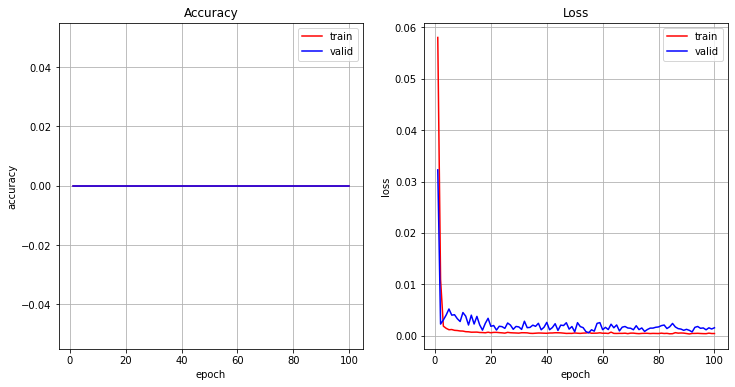

Evaluamos el modelo en train_score: [0.0015312156174331903, 0.0]
29/29 [==============================] - 1s 3ms/step
Predecimos con los datos de train: 0.03225688492100812
Predecimos con los datos de train_cantidad/dimensiones de datos:(917, 1)
 La media de error en la prediccion en entrenamiento es: 0.4504619401826611
15/15 [==============================] - 0s 3ms/step
 El  error de la predicion usando datos de test es de : 0.03177818452411202
 La media de error en la prediccion en test es: 0.4482440421756857
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
15/15 [==============================] - 0s 4ms/step
17
(17, 54)


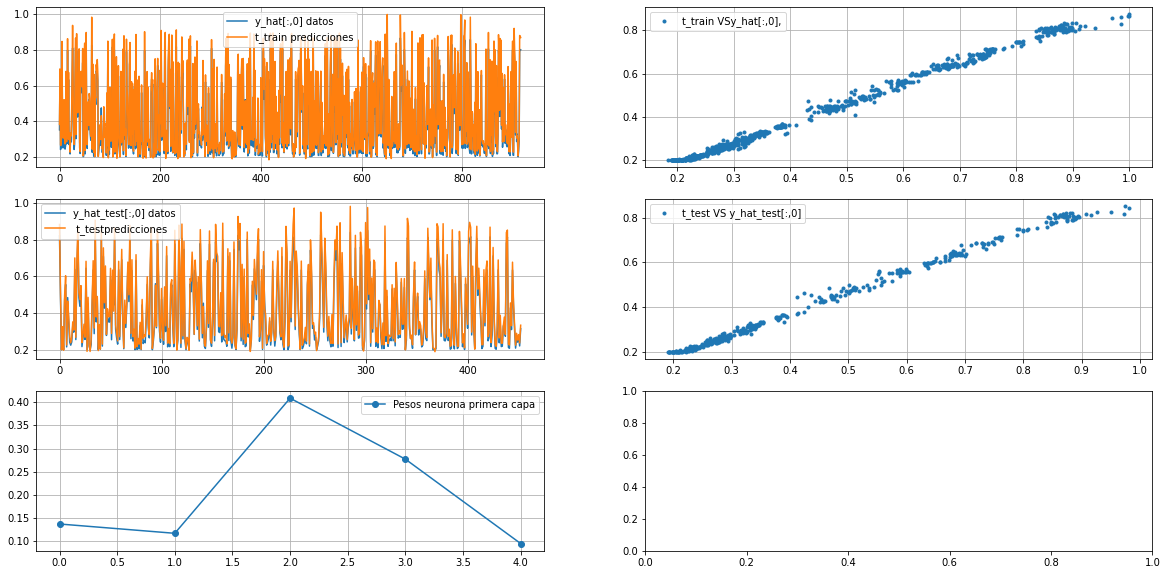

In [16]:
DAT = sacar_open_5_valores_normalizado_y_con_numero_de_valores_SIN_RETORNO_LOG_AMAZON ()
x_train, x_test, t_train, t_test =Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG=11,DAT_1=DAT)
model, hist = activo_caso_1(x_train, x_test, t_train, t_test)
model_title = 'EJ_9_CASO_1_GDN(input_shape_Conv1D(10, 3_MaxPooling1D(2_LSTM(5_GRU(5_Dense(1_NORMALIZADO_SIN_RETORNO_LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn_1 (GDN)                 (None, 10, 5)             90        
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 10)            160       
                                                                 
 gru_1 (GRU)                 (None, 10, 5)             255       
                                                                 
 lstm_1 (LSTM)               (None, 5)                 220       
                                                                 
 flatten_1 (Flatten)         (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 731
Trainable params: 731
Non-trainable 

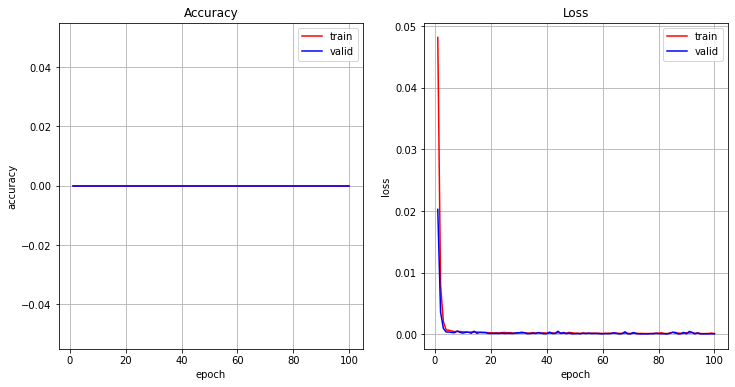

Evaluamos el modelo en train_score: [0.00011878710211021826, 0.0]
29/29 [==============================] - 1s 4ms/step
Predecimos con los datos de train: 0.007980045401897616
Predecimos con los datos de train_cantidad/dimensiones de datos:(917, 1)
 La media de error en la prediccion en entrenamiento es: 0.4504619401826611
15/15 [==============================] - 0s 4ms/step
 El  error de la predicion usando datos de test es de : 0.007971910056877614
 La media de error en la prediccion en test es: 0.4482440421756857
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
15/15 [==============================] - 0s 3ms/step
17
(17, 54)


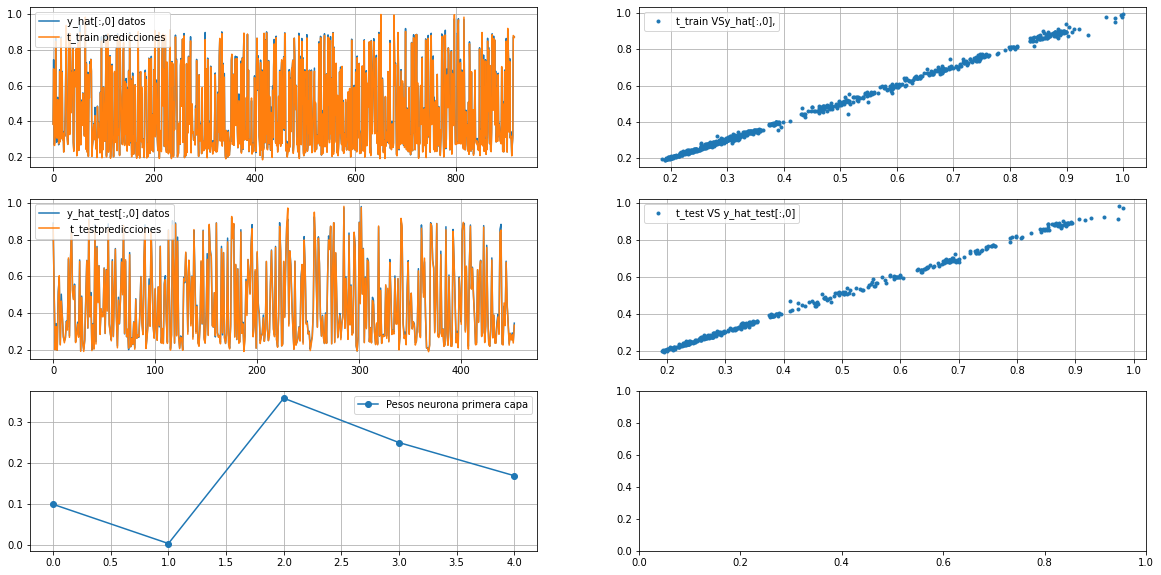

In [17]:
#DAT = sacar_open_5_valores_normalizado_y_con_numero_de_valores_SIN_RETORNO_LOG_AMAZON ()
#x_train, x_test, t_train, t_test =Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG=11,DAT_1=DAT)
model, hist = activo_caso_2(x_train, x_test, t_train, t_test)
model_title = 'EJ_9_CASO_2_GDN(input_shape_Conv1D(10,3_GRU(5_LSTM(5_Dense(1_NORMALIZADO_SIN_RETORNO_LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn_2 (GDN)                 (None, 10, 5)             90        
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 5)             80        
                                                                 
 conv1d_3 (Conv1D)           (None, 8, 5)              80        
                                                                 
 flatten_2 (Flatten)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 123       
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 377
Trainable params: 377
Non-trainable 

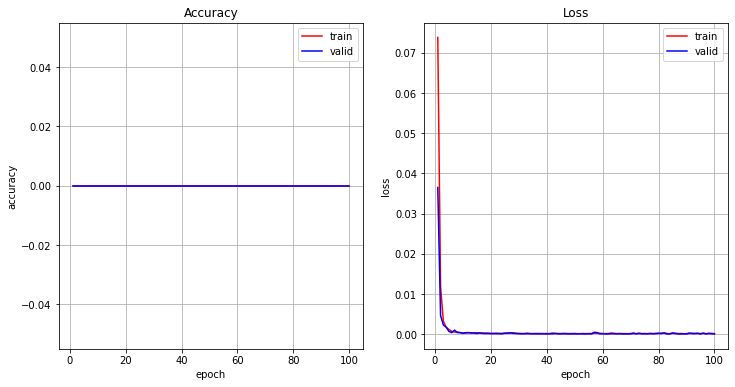

Evaluamos el modelo en train_score: [8.979896665550768e-05, 0.0]
29/29 [==============================] - 0s 3ms/step
Predecimos con los datos de train: 0.0063938469558031345
Predecimos con los datos de train_cantidad/dimensiones de datos:(917, 1)
 La media de error en la prediccion en entrenamiento es: 0.4504619401826611
15/15 [==============================] - 0s 3ms/step
 El  error de la predicion usando datos de test es de : 0.006257355551643097
 La media de error en la prediccion en test es: 0.4482440421756857
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
15/15 [==============================] - 0s 2ms/step
17
(17, 54)


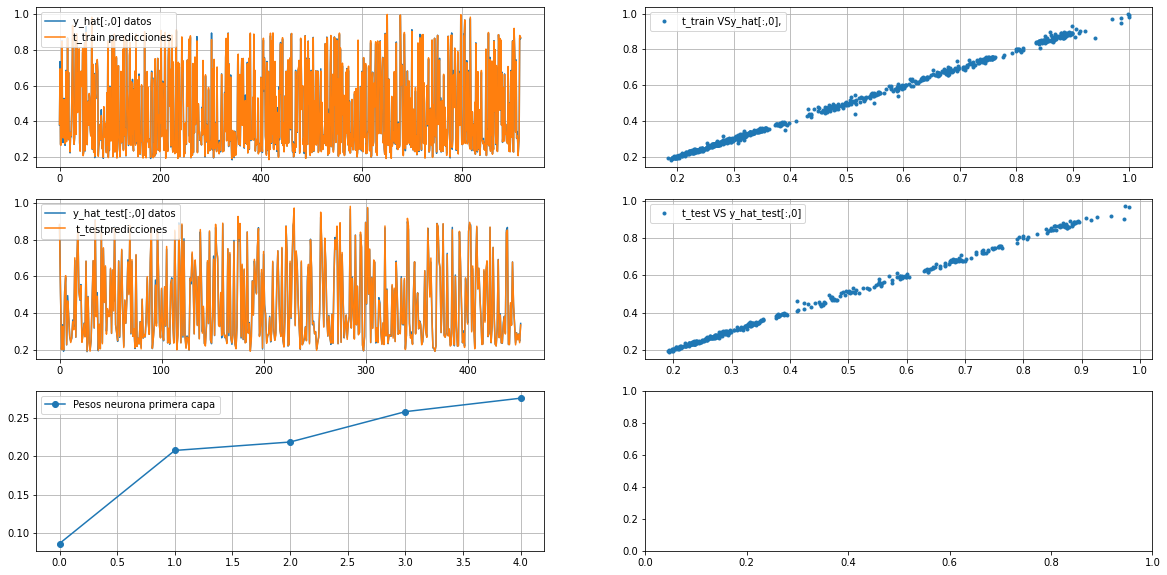

In [18]:
#DAT = sacar_open_5_valores_normalizado_y_con_numero_de_valores_SIN_RETORNO_LOG_AMAZON ()
#x_train, x_test, t_train, t_test =Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG=11,DAT_1=DAT)
model, hist = activo_caso_3(x_train, x_test, t_train, t_test)
model_title = 'EJ_9_CASO_3_GDN(input_shape_Conv1D(5, 3_Conv1D(5, 3_Dense(3_Dense(1_NORMALIZADO_SIN_RETORNO_LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn_3 (GDN)                 (None, 10, 5)             90        
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 8)             128       
                                                                 
 batch_normalization (BatchN  (None, 10, 8)            32        
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 10, 8)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 10, 3)             123       
                                                                 
 batch_normalization_1 (Batc  (None, 10, 3)            12        
 hNormalization)                                      

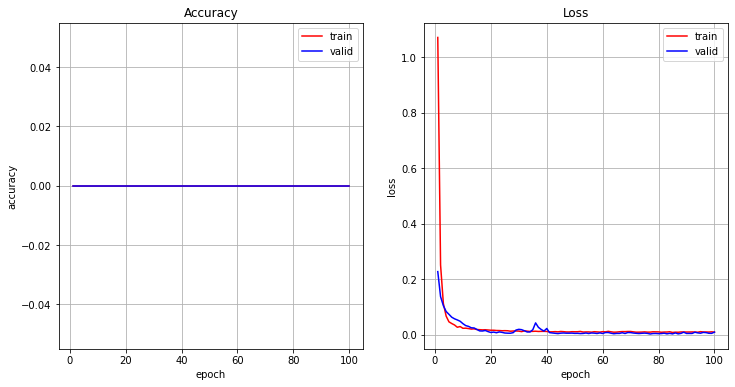

Evaluamos el modelo en train_score: [0.008496561087667942, 0.0]
29/29 [==============================] - 0s 3ms/step
Predecimos con los datos de train: 0.07894629489353597
Predecimos con los datos de train_cantidad/dimensiones de datos:(917, 1)
 La media de error en la prediccion en entrenamiento es: 0.4504619401826611
15/15 [==============================] - 0s 3ms/step
 El  error de la predicion usando datos de test es de : 0.07679648132449989
 La media de error en la prediccion en test es: 0.4482440421756857
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
15/15 [==============================] - 0s 2ms/step
17
(17, 54)


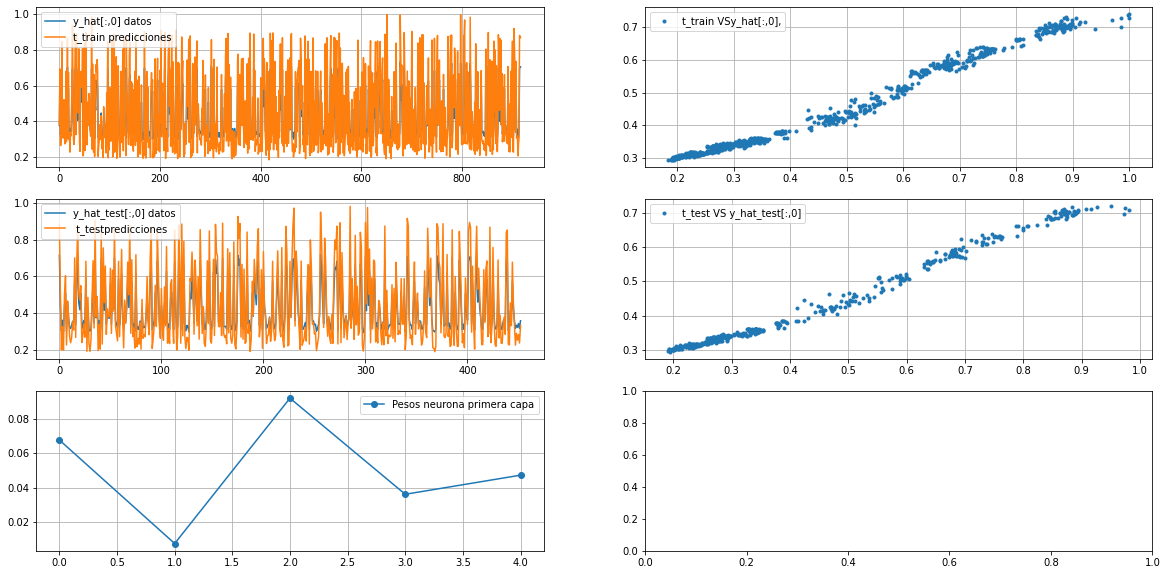

In [19]:
#DAT = sacar_open_5_valores_normalizado_y_con_numero_de_valores_SIN_RETORNO_LOG_AMAZON ()
#x_train, x_test, t_train, t_test =Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG=11,DAT_1=DAT)
model, hist = activo_caso_4(x_train, x_test, t_train, t_test)
model_title = 'EJ_9_CASO_4_GDN(input_shape_Conv1D(8_Conv1D(3_MaxPooling1D(_Conv1D(3_Dense(1_NORMALIZADO_SIN_RETORNO_LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)

(5153,)
(7983,)
(1381,)
(8364,)
(3333,)


<ipython-input-8-a75396a71592>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_x = DAT_TS[range(0,np.int(Ntr)),0:LAG-1,:]
<ipython-input-8-a75396a71592>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumP

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn_4 (GDN)                 (None, 10, 5)             90        
                                                                 
 conv1d_7 (Conv1D)           (None, 10, 10)            160       
                                                                 
 activation_1 (Activation)   (None, 10, 10)            0         
                                                                 
 dropout_4 (Dropout)         (None, 10, 10)            0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 5, 10)            0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 5, 5)              320       
                                                      

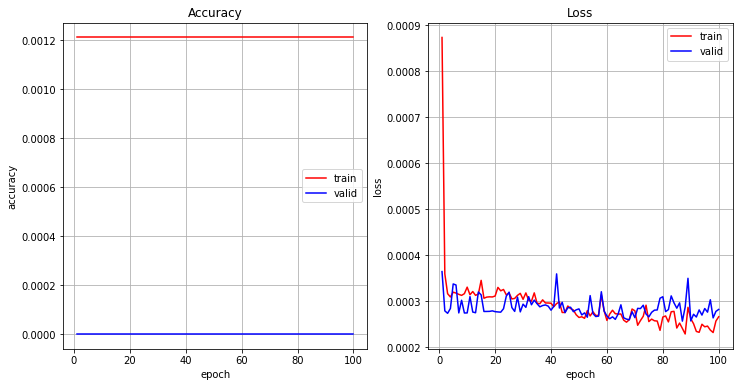

Evaluamos el modelo en train_score: [0.000238661581533961, 0.0010905124945566058]
29/29 [==============================] - 1s 3ms/step
Predecimos con los datos de train: 0.011131871530945749
Predecimos con los datos de train_cantidad/dimensiones de datos:(917, 1)
 La media de error en la prediccion en entrenamiento es: 0.01181060970367004
15/15 [==============================] - 0s 3ms/step
 El  error de la predicion usando datos de test es de : 0.012566886161896522
 La media de error en la prediccion en test es: 0.012511735923330478
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
15/15 [==============================] - 0s 3ms/step
17
(17, 54)


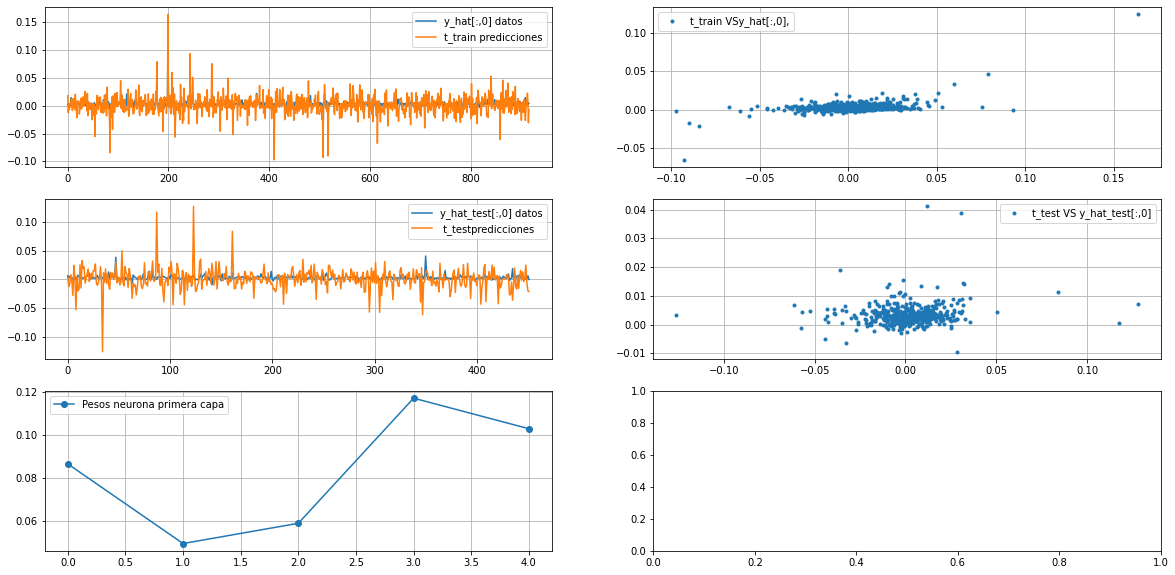

In [20]:
DAT = sacar_open_5_valores_SIN_normalizado_y_con_numero_de_valores_CON_RETORNO_LOG_AMAZON ()
x_train, x_test, t_train, t_test =Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG=11,DAT_1=DAT)
model, hist = activo_caso_1(x_train, x_test, t_train, t_test)
model_title = 'EJ_9_CASO_1_GDN(input_shape_Conv1D(10, 3_MaxPooling1D(2_LSTM(5_GRU(5_Dense(1_CON_RETORNO_LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn_5 (GDN)                 (None, 10, 5)             90        
                                                                 
 conv1d_8 (Conv1D)           (None, 10, 10)            160       
                                                                 
 gru_3 (GRU)                 (None, 10, 5)             255       
                                                                 
 lstm_3 (LSTM)               (None, 5)                 220       
                                                                 
 flatten_5 (Flatten)         (None, 5)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 6         
                                                                 
Total params: 731
Trainable params: 731
Non-trainable 

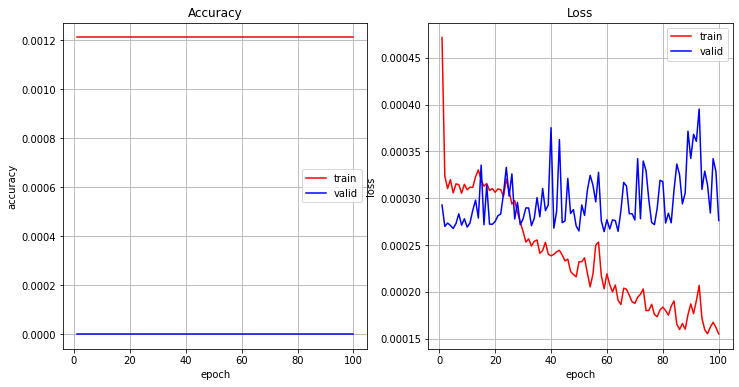

Evaluamos el modelo en train_score: [0.00017490587197244167, 0.0010905124945566058]
29/29 [==============================] - 1s 3ms/step
Predecimos con los datos de train: 0.00979123735468344
Predecimos con los datos de train_cantidad/dimensiones de datos:(917, 1)
 La media de error en la prediccion en entrenamiento es: 0.01181060970367004
15/15 [==============================] - 0s 3ms/step
 El  error de la predicion usando datos de test es de : 0.014094434339180027
 La media de error en la prediccion en test es: 0.012511735923330478
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
15/15 [==============================] - 0s 4ms/step
17
(17, 54)


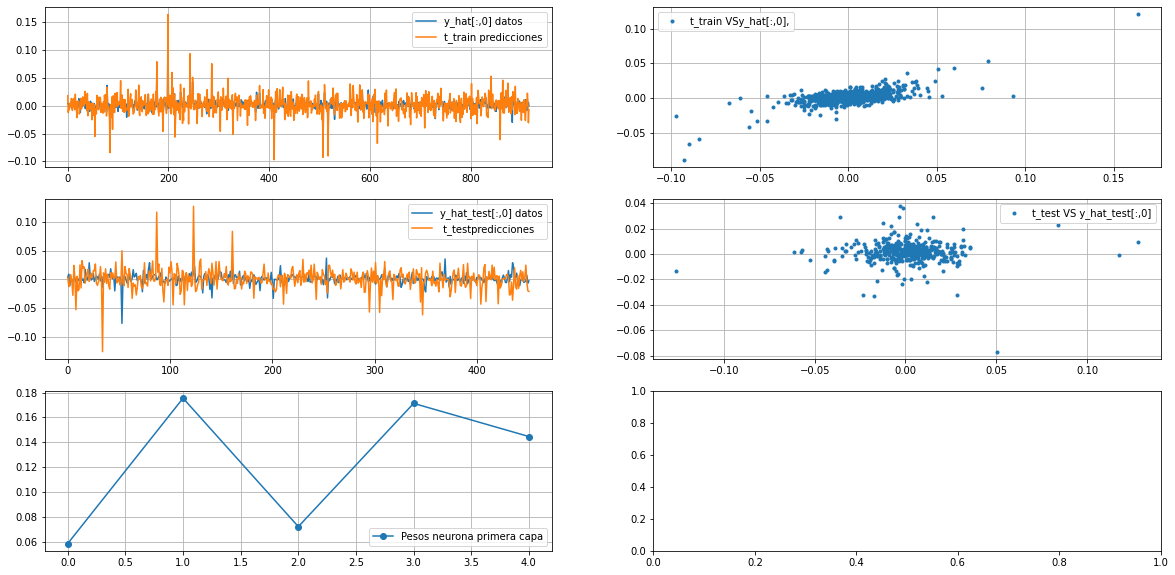

In [21]:
#DAT = sacar_open_5_valores_SIN_normalizado_y_con_numero_de_valores_CON_RETORNO_LOG_AMAZON ()
#x_train, x_test, t_train, t_test =Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG=11,DAT_1=DAT)
model, hist = activo_caso_2(x_train, x_test, t_train, t_test)
model_title = 'EJ_9_CASO_2_GDN(input_shape_Conv1D(10,3_GRU(5_LSTM(5_Dense(1_CON_RETORNO_LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn_6 (GDN)                 (None, 10, 5)             90        
                                                                 
 conv1d_9 (Conv1D)           (None, 10, 5)             80        
                                                                 
 conv1d_10 (Conv1D)          (None, 8, 5)              80        
                                                                 
 flatten_6 (Flatten)         (None, 40)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 123       
                                                                 
 dense_8 (Dense)             (None, 1)                 4         
                                                                 
Total params: 377
Trainable params: 377
Non-trainable 

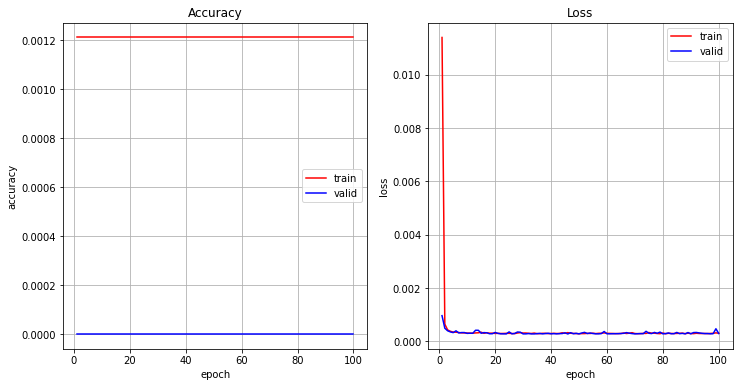

Evaluamos el modelo en train_score: [0.00028209935408085585, 0.0010905124945566058]
29/29 [==============================] - 0s 2ms/step
Predecimos con los datos de train: 0.01176697506313286
Predecimos con los datos de train_cantidad/dimensiones de datos:(917, 1)
 La media de error en la prediccion en entrenamiento es: 0.01181060970367004
15/15 [==============================] - 0s 2ms/step
 El  error de la predicion usando datos de test es de : 0.013589256601851648
 La media de error en la prediccion en test es: 0.012511735923330478
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
15/15 [==============================] - 0s 2ms/step
17
(17, 54)


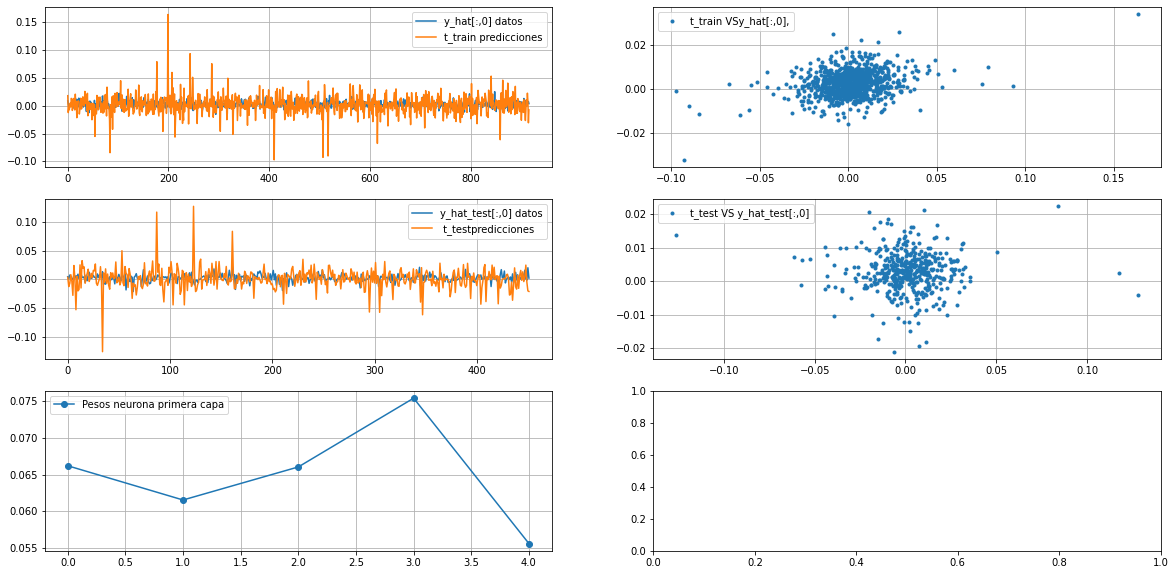

In [22]:
#DAT = sacar_open_5_valores_SIN_normalizado_y_con_numero_de_valores_CON_RETORNO_LOG_AMAZON ()
#x_train, x_test, t_train, t_test =Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG=11,DAT_1=DAT)
model, hist = activo_caso_3(x_train, x_test, t_train, t_test)
model_title = 'EJ_9_CASO_3_GDN(input_shape_Conv1D(5, 3_Conv1D(5, 3_Dense(3_Dense(1_CON_RETORNO_LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)

In [ ]:
#DAT = sacar_open_5_valores_SIN_normalizado_y_con_numero_de_valores_CON_RETORNO_LOG_AMAZON ()
#x_train, x_test, t_train, t_test =Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG=11,DAT_1=DAT)
model, hist = activo_caso_4(x_train, x_test, t_train, t_test)
model_title = 'EJ_9_CASO_4_GDN(input_shape_Conv1D(8_Conv1D(3_MaxPooling1D(_Conv1D(3_Dense(1_NORMALIZADO_CON_RETORNO_LOG.'
salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn_7 (GDN)                 (None, 10, 5)             90        
                                                                 
 conv1d_11 (Conv1D)          (None, 10, 8)             128       
                                                                 
 batch_normalization_3 (Batc  (None, 10, 8)            32        
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 10, 8)             0         
                                                                 
 conv1d_12 (Conv1D)          (None, 10, 3)             123       
                                                                 
 batch_normalization_4 (Batc  (None, 10, 3)            12        
 hNormalization)                                      

In [ ]:
# CONCLUSIONES:
# ENTIENDO QUE HE ECHO LO QUE PIDE EN ENUNCIADO AUNQEU NO HE OPTIMIZADO LOS HIPERPARAMETROS
# COMPARANDO LAS GRAFICAS Y VALORES, PUEDO DECIR:

# 'EJ_9_CASO_1_GDN(input_shape_Conv1D(10, 3_MaxPooling1D(2_LSTM(5_GRU(5_Dense(1_NORMALIZADO_SIN_RETORNO_LOG.' 
# SCORE DE TRAIN:[0.007062689866870642, 0.0]
# SCORE DE TEST:[0.0069668591022491455, 0.0]
# TIENE BIAS COMO SE VE EN LAS GRAFICAS T_TRAIN Y T_TEST VS Y_HAT[0] QUE SE VE EN LOS NUMERO QUE TIENE QUE PREDECIR HACIA EL 1

# 'EJ_9_CASO_2_GDN(input_shape_Conv1D(10,3_GRU(5_LSTM(5_Dense(1_NORMALIZADO_SIN_RETORNO_LOG.'
# SCORE DE TRAIN: [0.00015315256314352155, 0.0]
# SCORE DE TEST: [0.0001444663357688114, 0.0]
# ESTE MODELO ES EL QUE MAS ME GUSTA EN GRAFICAS Y EN VALORES DE TEST LOSS

# 'EJ_9_CASO_3_GDN(input_shape_Conv1D(5, 3_Conv1D(5, 3_Dense(3_Dense(1_NORMALIZADO_SIN_RETORNO_LOG.'
# SCORE DE TRAIN:[0.000256613566307351, 0.0]
# SCORE DE TEST:[0.0002570754149928689, 0.0]
# PARECE UN MODELO DECENTE AL MIRAR LAS GRAFICAS

# 'EJ_9_CASO_4_GDN(input_shape_Conv1D(8_Conv1D(3_MaxPooling1D(_Conv1D(3_Dense(1_NORMALIZADO_SIN_RETORNO_LOG.'
# SCORE DE TRAIN:[0.006580200046300888, 0.0]
# SCORE DE TEST:[0.006472317036241293, 0.0]
# LAS FIGURAS DE PUNTOS SON CON MUCHO BIAS. NO ME GUSTAN NADA. DESCARTARIA

# 'EJ_9_CASO_1_GDN(input_shape_Conv1D(10, 3_MaxPooling1D(2_LSTM(5_GRU(5_Dense(1_CON_RETORNO_LOG.'
# SCORE DE TRAIN:[0.0002740990312304348, 0.0010905124945566058]
# SCORE DE TEST:[0.00038907749694772065, 0.0]
# # DA BUENOS VALORES DE LOSS PERO NO ME GUSTA LA DISTRIBUCION DE PESOS. CREO QEU NECESITA REGULARIZAR
# PARA QUE DISTRIBUJA MEJOR LOS PESOS

# 'EJ_9_CASO_2_GDN(input_shape_Conv1D(10,3_GRU(5_LSTM(5_Dense(1_CON_RETORNO_LOG.'
# SCORE DE TRAIN: [0.00018461588479112834, 0.0010905124945566058]
# SCORE DE TEST: [0.00047042235382832587, 0.0]
# ME GUSTAN LAS GRAFICAS T_TRAIN Y T_TEST VS Y_HAT[0] YA QUE SE EMPIEZA A GENERAR UNA RAYA DE 45 GRADOS
# QUE ES LO QUE DEBERIA SALIR. ESTE MODELO ME GUSTA POR ESO Y EL SCORE DE TEST DEL LOSS ES DECENTE
# CREO QUE PODRIA MEJORAR SI JUGRARA CON LOS HIPERPARAMETROS

# 'EJ_9_CASO_3_GDN(input_shape_Conv1D(5, 3_Conv1D(5, 3_Dense(3_Dense(1_CON_RETORNO_LOG.'
# SCORE DE TRAIN:[0.0002777133777271956, 0.0010905124945566058]
# SCORE DE TEST:[0.00038654281524941325, 0.0]

# 'EJ_9_CASO_4_GDN(input_shape_Conv1D(8_Conv1D(3_MaxPooling1D(_Conv1D(3_Dense(1_NORMALIZADO_CON_RETORNO_LOG.'
# SCORE DE TRAIN:[0.00030730405705980957, 0.0010905124945566058]
# SCORE DE TEST:[0.00036797969369217753, 0.0]
# TIENE BIAS COMO SE VE EN LAS GRAFICAS T_TRAIN Y T_TEST VS Y_HAT[0] QUE LOS PUNTOS NO ESTAN ALREDEDOR DEL 0,0



